# Chunin Exams Food Track- CV'2021


### **Achieved an F1 Score of 0.479**
Main method used: 
    1) Data Augmentation<br>
    2) Duplicated the dataset and added extra augmentation to that to make a larger dataset<br>
    3) Used Resnet18 with 20 epochs<br>

## Import Libraries

In [18]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn import preprocessing
from torchvision import transforms, utils
from torchvision import models
from torch.utils.data.sampler import SubsetRandomSampler
import cv2
from sklearn.metrics import f1_score,precision_score,log_loss
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

## Import Data

In [2]:
table = pd.read_csv('data/train/train.csv')
Label_Encode = preprocessing.LabelEncoder()
Labels = Label_Encode.fit_transform(table['ClassName'])
trainData = table
trainData['ClassName'] = Labels
print(trainData)


             ImageId  ClassName
0     f27632d7e5.jpg         55
1     efa87919ed.jpg         41
2     4f169e8c8d.jpg         12
3     a6956654bf.jpg         44
4     d99ce8c3bf.jpg         23
...              ...        ...
9318  ba8233c7d2.jpg          7
9319  2090043907.jpg         58
9320  8762d1cefd.jpg         14
9321  28e7439245.jpg         12
9322  ba263cfb41.jpg         21

[9323 rows x 2 columns]


### Duplicate the dataset to augment data and increase total images available for training


In [3]:
augData = trainData.copy(deep=True)
trainData['augData'] =  [0]*len(trainData)
augData['augData'] = [1]*len(augData)
combo = pd.concat([trainData,augData],ignore_index=True)
print(combo)
print(combo[9318:9327])

              ImageId  ClassName  augData
0      f27632d7e5.jpg         55        0
1      efa87919ed.jpg         41        0
2      4f169e8c8d.jpg         12        0
3      a6956654bf.jpg         44        0
4      d99ce8c3bf.jpg         23        0
...               ...        ...      ...
18641  ba8233c7d2.jpg          7        1
18642  2090043907.jpg         58        1
18643  8762d1cefd.jpg         14        1
18644  28e7439245.jpg         12        1
18645  ba263cfb41.jpg         21        1

[18646 rows x 3 columns]
             ImageId  ClassName  augData
9318  ba8233c7d2.jpg          7        0
9319  2090043907.jpg         58        0
9320  8762d1cefd.jpg         14        0
9321  28e7439245.jpg         12        0
9322  ba263cfb41.jpg         21        0
9323  f27632d7e5.jpg         55        1
9324  efa87919ed.jpg         41        1
9325  4f169e8c8d.jpg         12        1
9326  a6956654bf.jpg         44        1


## Define Custom Dataloader

In [4]:
class FoodData(Dataset):
    def __init__(self,dataFile,fileDir,transform=None,transform_aug = None,train=True):
        super().__init__()
        self.data_list = dataFile
        self.data_dir = fileDir
        self.transform = transform
        self.transform_aug = transform_aug
        self.train = train
    
    def __len__(self):
        return self.data_list.shape[0]
    
    def __getitem__(self,item):
        if self.train:
            img_name = self.data_list.iloc[item]['ImageId']
            label = self.data_list.iloc[item]['ClassName']
        else:
              img_name = self.data_list.iloc[item]['ImageId']
        img_path = os.path.join(self.data_dir,img_name)
        img = cv2.imread(img_path,1)
        img = cv2.resize(img,(256,256))
        if self.train:
            augValue = self.data_list.iloc[item,-1]
            if augValue == 0:
                img = self.transform(img)
            if augValue == 1:
                img = self.transform_aug(img)
        else:
            if self.transform:
                img=self.transform(img)
            
        if self.train:
              return {'ImgVals' : img, 'labelId' : torch.tensor(label)}
        else:
              return {'ImgVals':img}

In [5]:
trainPath = 'data/train/train_images'

train_data = FoodData(dataFile = combo,
                           fileDir = trainPath,
                           transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5))
                            ]),
                          transform_aug = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.ToTensor(),
                                transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                                transforms.RandomHorizontalFlip(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5))
                            ]))

print(train_data)

In [6]:
#Store test data
testData = pd.read_csv('data/test/test.csv')
testPath = 'data/test/test_images/'
test_data = FoodData(dataFile = testData,
                           fileDir = testPath,
                           transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5))
                            ]),
                         train=False)
print(test_data)

## Split into training and validation set
We do a 80-20% division with a batch size of 64

In [7]:
batch_size = 64
valid_size = 0.2
num = train_data.__len__()
# Dividing the indices for train and cross validation
indices = list(range(num))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num))
train_idx,valid_idx = indices[split:], indices[:split]

#Create Samplers
train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(valid_idx)


trainDataLoader = DataLoader(train_data, 
                             batch_size=batch_size, 
                             num_workers=8,
                             pin_memory = True,
                             sampler=train_sampler)
validDataLoader = DataLoader(train_data, 
                             batch_size=batch_size,
                             num_workers=8,
                             pin_memory=True,
                             sampler=validation_sampler)

Here we load test images. Note: This file will not have any labels with it

In [8]:
#Test data
testDataLoader = DataLoader(test_data, 
                             num_workers=8,
                             pin_memory=True,
                             batch_size=batch_size)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## resnet18 is used as pretrained model

In [10]:
import torch.nn as nn
import torch.nn.functional as F

model = models.resnet18(pretrained=True)

Adam optimiser is used along with cross entropy loss function

In [11]:
import torch.optim as optim
#Loss Function
error = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters())

### Training the model for 20 epochs

In [12]:
n_epochs = 20
valid_loss_min = np.Inf
model.to(device)
train_losses = []
valid_losses = []

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
#     scheduler.step()
#     # Print Learning Rate
#     print('Epoch:', epoch,'LR:', scheduler.get_lr())
    model.train()
    for images in trainDataLoader:
        data = images['ImgVals'].squeeze(0).to(device)
        # data = data.squeeze(0)
        target = images['labelId'].to(device)
#             clear the gradients of all optimized variables
        optimizer.zero_grad()
#         forward pass the model
        output = model(data)
#     backward pass the model
        loss = error(output,target)
        loss.backward()
#         Perform a single optimization step
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        
    
    
    
    model.eval()
    for images in validDataLoader:
        data = images['ImgVals'].squeeze(0).to(device)
        target = images['labelId'].to(device)
#         forward pass now
        output = model(data)
#         calculate the branch loss
        loss = error(output, target)
#     update average validation loss
        valid_loss += loss.item()*data.size(0)
    
    train_loss /= len(trainDataLoader.sampler)
    valid_loss /= len(validDataLoader.sampler)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    if valid_loss <= valid_loss_min:
        print("Validation Loss decreased {:0.6f} -> {:0.6f}".format(valid_loss_min,valid_loss))
        valid_loss_min = valid_loss
        torch.save(model.state_dict(), 'Part2_Aug.pth')

Epoch: 0 	Training Loss: 2.469186 	Validation Loss: 2.438229
Validation Loss decreased inf -> 2.438229
Epoch: 1 	Training Loss: 1.751111 	Validation Loss: 2.131592
Validation Loss decreased 2.438229 -> 2.131592
Epoch: 2 	Training Loss: 1.395349 	Validation Loss: 1.912671
Validation Loss decreased 2.131592 -> 1.912671
Epoch: 3 	Training Loss: 1.091845 	Validation Loss: 1.701151
Validation Loss decreased 1.912671 -> 1.701151
Epoch: 4 	Training Loss: 0.782725 	Validation Loss: 1.670546
Validation Loss decreased 1.701151 -> 1.670546
Epoch: 5 	Training Loss: 0.664480 	Validation Loss: 1.333986
Validation Loss decreased 1.670546 -> 1.333986
Epoch: 6 	Training Loss: 0.414579 	Validation Loss: 1.286937
Validation Loss decreased 1.333986 -> 1.286937
Epoch: 7 	Training Loss: 0.293721 	Validation Loss: 1.072141
Validation Loss decreased 1.286937 -> 1.072141
Epoch: 8 	Training Loss: 0.225262 	Validation Loss: 0.936764
Validation Loss decreased 1.072141 -> 0.936764
Epoch: 9 	Training Loss: 0.160793

### Plot error functions vs epoch

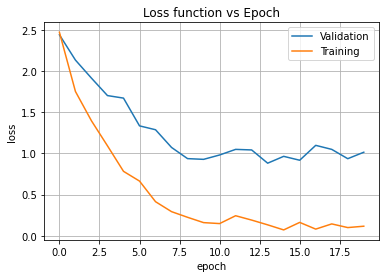

In [14]:
epoch= np.arange(20)
fig, ax = plt.subplots()
ax.plot(epoch, valid_losses,label='Validation')
ax.plot(epoch,train_losses,label='Training')
ax.grid()

ax.set(xlabel='epoch', ylabel='loss',
       title='Loss function vs Epoch')
leg = ax.legend();
fig.savefig("graph.png")
plt.show()

### Generate predictions for testdata

In [15]:
model.load_state_dict(torch.load('Part2_Aug.pth'))
model.eval()

preds = []
with torch.no_grad():
    for images in testDataLoader:
        data = images['ImgVals'].squeeze(0).to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        pr = predicted.detach().cpu().numpy()
        for i in pr:
              preds.append(i)


### Test accuracy by running the model on validation data

In [16]:
model.load_state_dict(torch.load('Part2_Aug.pth'))
model.eval()
correct = 0
total = 0
pred_list = []
correct_list = []
model.cuda()
with torch.no_grad():
    for images in validDataLoader:
        data = images['ImgVals'].squeeze(0).to(device)
        target = images['labelId'].to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        pr = predicted.detach().cpu().numpy()
        for i in pr:
                pred_list.append(i)
        tg = target.detach().cpu().numpy()
        for i in tg:
              correct_list.append(i)
        correct += (predicted == target).sum().item()

print('Accuracy of the network on the 10000 test images: %f %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 81.040493 %


## Save it in correct format for submission

In [17]:
# Create Submission file        
df = pd.DataFrame(Label_Encode.inverse_transform(preds),columns=['ClassName'])
df.to_csv('submissionOof.csv',index=False)